In [1]:
from lib.abstract_torch import get_device, get_loss, get_optimizer
from lib.dataloader import get_MNIST_loaders, get_FMNIST_loaders, get_CIFAR100_loaders, get_CIFAR10_loaders
from lib.model import ANN
from lib.train import train
from lib.test import test
from lib.growth_schedules import get_handcrafted_schedule
from lib.visualize import (visualize_pathes,
                          visualize_statistical_reliability,
                          visualize_box_plot)               

import os
import numpy as np

In [2]:
device = get_device()

In [3]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "\\data"

# MNIST

## Get data loaders

In [4]:
batch_size=128

In [5]:
train_loader, val_loader, test_loader = get_MNIST_loaders(data_path, range(10), batch_size)

## Random Initialization

In [6]:
init_name = "random"
savefig = "MNIST_random"

### Define, train and test both root & target models

In [8]:
# Network's initial architecture
num_inputs = 28*28
num_hidden_root = 10
num_outputs = 10

# Network's final architecture
num_hidden_target = 100

# Loss & optimizer
loss_name = "MSE" # "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 5e-3
growth_schedule = None

# Experiment parameters
num_repetitions = 1

#### Root model

In [9]:
test_acc_roots = []
for i in range(num_repetitions) :
    root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
    _ = train(root_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_root = test(root_model, test_loader, batch_size, device)
    test_acc_roots.append(test_acc_root)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.63s/it]


In [10]:
test_acc_roots

[58.453461538461546]

#### Target model

In [11]:
test_acc_targets = []
for i in range(num_repetitions) :
    target_model = ANN(num_inputs, num_hidden_target, num_outputs).to(device)
    _ = train(target_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_target = test(target_model, test_loader, batch_size, device)
    test_acc_targets.append(test_acc_target)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.71s/it]


In [12]:
test_acc_targets

[94.45192307692308]

### Grow root model

In [34]:
# Growth parameters
num_neurons = 9

In [35]:
growth_schedules = get_handcrafted_schedule(num_neurons)

In [17]:
len(iter(train_loader))

328

In [18]:
def get_number_batches(loader, num_epochs) :
    return len(iter(loader)) * num_epochs

In [19]:
get_number_batches(train_loader, num_epochs)

984

All params :
- num epochs
- batch_size
- num neurons
- num growth
- num_hidden_root
- num_hidden_target

Ok qu'est ce qu'on veut garder fixe ?
- On veut comparer différents growth schedule à travers le temps
- La dimension temporelle est complètement décorellée des dimensions spatiales ?
- Non : effets de bord, notre growth schedule fait qu'on ne peut pas grandir trop vite
- Mais à part ça, oui, c'est décorellé
- Donc ça peut se concrétiser en disant simplement qu'il doit y avoir une time step (un batch) entre chaque growth.
- Donc ouais étant donné un schedule de spatial growth, on le transforme en temporal schedule en indiquant à quel batch on fait chaque growth.

In [32]:
def get_temporal_schedule (spatial_schedule, growth_times) :
    if len(spatial_schedule) == len(growth_times) :
        pass
    else :
        print("You have to provide as many growth times as you scheduled growth")
    
    temporal_schedule = {}
    for growth, growth_time in zip(spatial_schedule, growth_times) :
        temporal_schedule[growth_time] = growth
    return temporal_schedule

In [33]:
get_temporal_schedule([], [2,3])

{2: 0, 3: 1}

In [36]:
def f_test (x, n_root, n_target) :
    return n_root*(n_target/n_root)**x

In [44]:
n_root, n_target = 10, 100
n_t = 928
c_t = 100
c_n = 
num_neuron = 13

In [46]:
c_n_tobe = c_n+num_neuron

In [49]:
possible_t = np.arange(c_t, n_t)
np.argmin(np.abs(f_test(possible_t/n_t, n_root, n_target) - c_n_tobe))

661

In [83]:
import matplotlib.pyplot as plt

In [90]:
n_t = 928
n_g = 20
normalized_timesteps = np.array([i/n_g for i in range(n_g+1)])

In [91]:
normalized_timesteps

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [157]:
def f (x) :
    return np.log(6*x+0.1)

In [185]:
def f(x):
    return np.where(x <= 0.5, 5*x, 2*x)

In [186]:
updated_timesteps = f(normalized_timesteps)

In [187]:
updated_timesteps = (updated_timesteps-updated_timesteps[0])/updated_timesteps[-1]

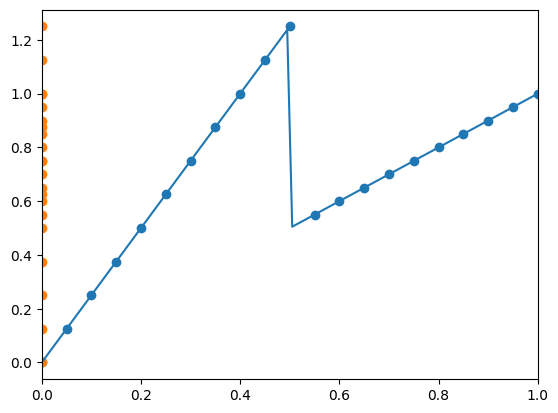

In [189]:
x = np.linspace(0, 1, 100) 
y = (f(x)-f(x)[0])/f(x)[-1]
plt.plot(x, y)
plt.scatter(normalized_timesteps, updated_timesteps)
plt.scatter([0]*len(updated_timesteps), updated_timesteps)
plt.xlim(0,1)
#plt.ylim(0,1)
plt.show()

In [190]:
updated_timesteps = (updated_timesteps*n_t).astype(int)

(0.0, 100.0)

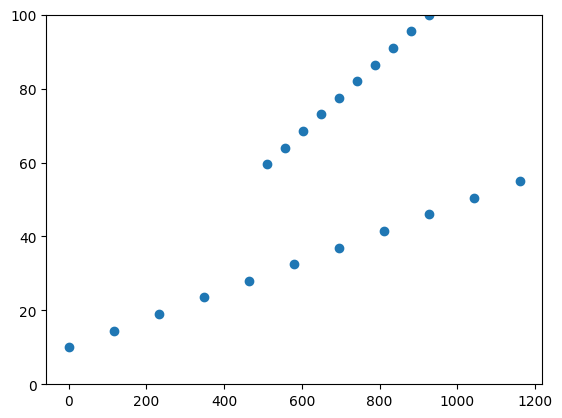

In [191]:
plt.scatter(updated_timesteps, np.linspace(n_root, n_target, 21))
plt.ylim(0,n_target)

In [171]:
test_accs_repeted = []
for i in range(num_repetitions) :
    test_accs = []
    for growth_schedule in growth_schedules :
        root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
        _ = train(root_model,
                  num_outputs,
                  growth_schedule,
                  loss_name, 
                  optimizer_name, lr, 
                  train_loader, val_loader, 
                  num_epochs, batch_size, 
                  device,
                  init_name=init_name,
                  verbose=0)
        test_acc = test(root_model, test_loader, batch_size, device)
        test_accs.append(test_acc)
    test_accs_repeted.append(test_accs)

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:31<00:15, 15.89s/it]


KeyboardInterrupt: 

In [15]:
test_accs_repeted = np.array(test_accs_repeted)
test_accs = np.mean(test_accs_repeted, 0)

### Visualize results